If you are viewing the HTML, the notebook can be found [here.](https://github.com/esacinc/PDC-Public/blob/master/API_documentation/PDC_clustergram.ipynb)

This notebook attempts to demonstrate the following:

1. Use the Proteome Data Commons (PDC) API to retrieve protein relative expression data for a [CPTAC](https://proteomics.cancer.gov/programs/cptac) study.  The PDC uses values produced by the Common Data Analysis Pipeline ([CDAP](https://cptac-data-portal.georgetown.edu/cptac/documents/CDAP_ProteinReports_description_20160503.pdf)).  More information on the PDC implementation of the CDAP can be found [here](https://pdc.esacinc.com/data-dictionary/harmonization.html).  <u>Note</u>: TMT/iTRAQ data are provided as log2ratios, where the denominator is a control channel.  In general, control channels are different between studies so comparisons *between* studies using these values are not currently recomended in the absence of bridging data.
2. Use the PDC API to retrieve the associated clinical metadata for all samples
3. Format the data for analysis using pandas
4. Cluster and visualize the data using the Seaborn clustermap package

The results are intended to help identify clusters of samples (tumors) displaying similar patterns of protein expression.

These are the required imports.  Install them using pip, if needed.

In [61]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

Next, set up the query parameters.

The first one is **pdc_submitter_id**.  This example is for the ccRCC whole proteome study.  PDC sample identifiers are available on the portal.


In [62]:
pdc_study_id = 'PDC000127'

The next one is **data type**. 
A table of data_types is available [here](https://pdc.cancer.gov/data-dictionary/publicapi-documentation/#!/Paginated_Records/paginatedDataMatrix).  A description of how these values are computed can be found [here](https://cptac-data-portal.georgetown.edu/cptac/documents/CDAP_ProteinReports_description_20160503.pdf).  In brief, these values are log2 transformed ratio data, where aliquot is the numerator and the denominator is a pooled, reference sample.  Ratios are calculated following normalization in the CPTAC Common Data Analysis Pipeline (CDAP.)

In [63]:
data_type = 'log2_ratio'  # Retrieves CDAP iTRAQ or TMT data

Note: All PDC APIs now require a default parameter - **'acceptDUA: true'** to ensure users are aware of the PDC embargo guidelines. Visit <a href="https://pdc.cancer.gov/data-dictionary/publicapi-documentation/" target="_blank">PDC API swagger page</a> to learn about this parameter and visit <a href="https://pdc.cancer.gov/pdc/data-use-guidelines" target="_blank">PDC data use page</a> to learn about the PDC data use guidelines.

Finally, we are ready to build the query string using **pdc_study_id** and **data_type**.

In [64]:
quant_data_query = '''
{ 
    quantDataMatrix(
    pdc_study_id: "''' + pdc_study_id +'''" data_type: "''' + data_type + '''" acceptDUA: true
    )
}'''

Now, we can define a function to make the [GraphQL](https://graphql.org/learn/) query.  This will get called once for the gene expression data and once for the clinical data.  If you are new to GraphQL, you can also try your queries [here](https://pdc.esacinc.com/graphql).

In [67]:
def query_pdc(query):
    # PDC API url
    url = 'https://pdc.cancer.gov/graphql'
    
    # Send the POST graphql query
    print('Sending query.')
    pdc_response = requests.post(url, json={'query': query})
    
    # Check the results
    if pdc_response.ok:
        # Decode the response
        return pdc_response.json()
    else:
        # Response not OK, see error
        return pdc_response.raise_for_status()

Now, we are ready to make the first API call.

In [68]:
decoded = query_pdc(quant_data_query)

# You may want to check this for an error, here

Sending query.


In [47]:
matrix = decoded['data']['quantDataMatrix']

Next, load the data into a dataframe.

In [48]:
# Aliquots are first row, gene names are first column
ga = pd.DataFrame(matrix[1:], columns=matrix[0]).set_index('Gene/Aliquot')
print(ga.shape)

(9591, 207)


The first number above is the number of genes and the second is the number of samples (i.e., aliquots) in the returned data set.

Since the expression values are returned as strings, we need to convert those to floats and deal with missing data.

In [49]:
for col in ga.keys():
    ga[col] = pd.to_numeric(ga[col], errors='coerce')

The clustermap module within the Seaborn package does not allow for NaN values.  So we must create a mask value that does not interfere much with the clustering and is likely to be unique.  No imputation is used.  By using a value close to 0, we are saying that these are unchanged between samples.  Better solutions should be used to deal with missing data points.

In [50]:
mask_na = 0.000666
ga = ga.fillna(mask_na)

Next, build the clinical data query.  This API needs only a **study_submitter_id** as input.  We will be retrieving 5 fields and using 2 in our clustergram.

In [51]:
metadata_query = '''
    {
        clinicalMetadata(pdc_study_id: "''' + pdc_study_id + '''" acceptDUA: true) {
            aliquot_submitter_id
            morphology
            primary_diagnosis
            tumor_grade
            tumor_stage
        }
    }
    '''

Next, let's query for the clinical metadata.  This will be used to annotate the columns (aliquots) to look for correlations between clinical attributes and samples.  That data are loaded into a dataframe after the query returns.

In [52]:
decoded = query_pdc(metadata_query)

Sending query.


In [53]:
print(len(decoded))
clin_matrix = decoded['data']['clinicalMetadata']
metadata = pd.DataFrame(clin_matrix, columns=clin_matrix[0]).set_index('aliquot_submitter_id')

1


We can then set up a color mapping function for the clinical annotations.

In [54]:
def get_colors(df, name, color) -> pd.Series:
    s = df[name]
    su = s.unique()
    colors = sns.light_palette(color, len(su))
    lut = dict(zip(su, colors))
    return s.map(lut)

Next, call get_colors() to map the tumor_stage and primary_diagnosis attributes.  Others are available.

In [55]:
stage_col_colors = get_colors(metadata, 'tumor_stage', 'red')
diagnosis_col_colors = get_colors(metadata, 'primary_diagnosis', 'green')

And, finally, generate the large clustermap using seaborn.clustermap

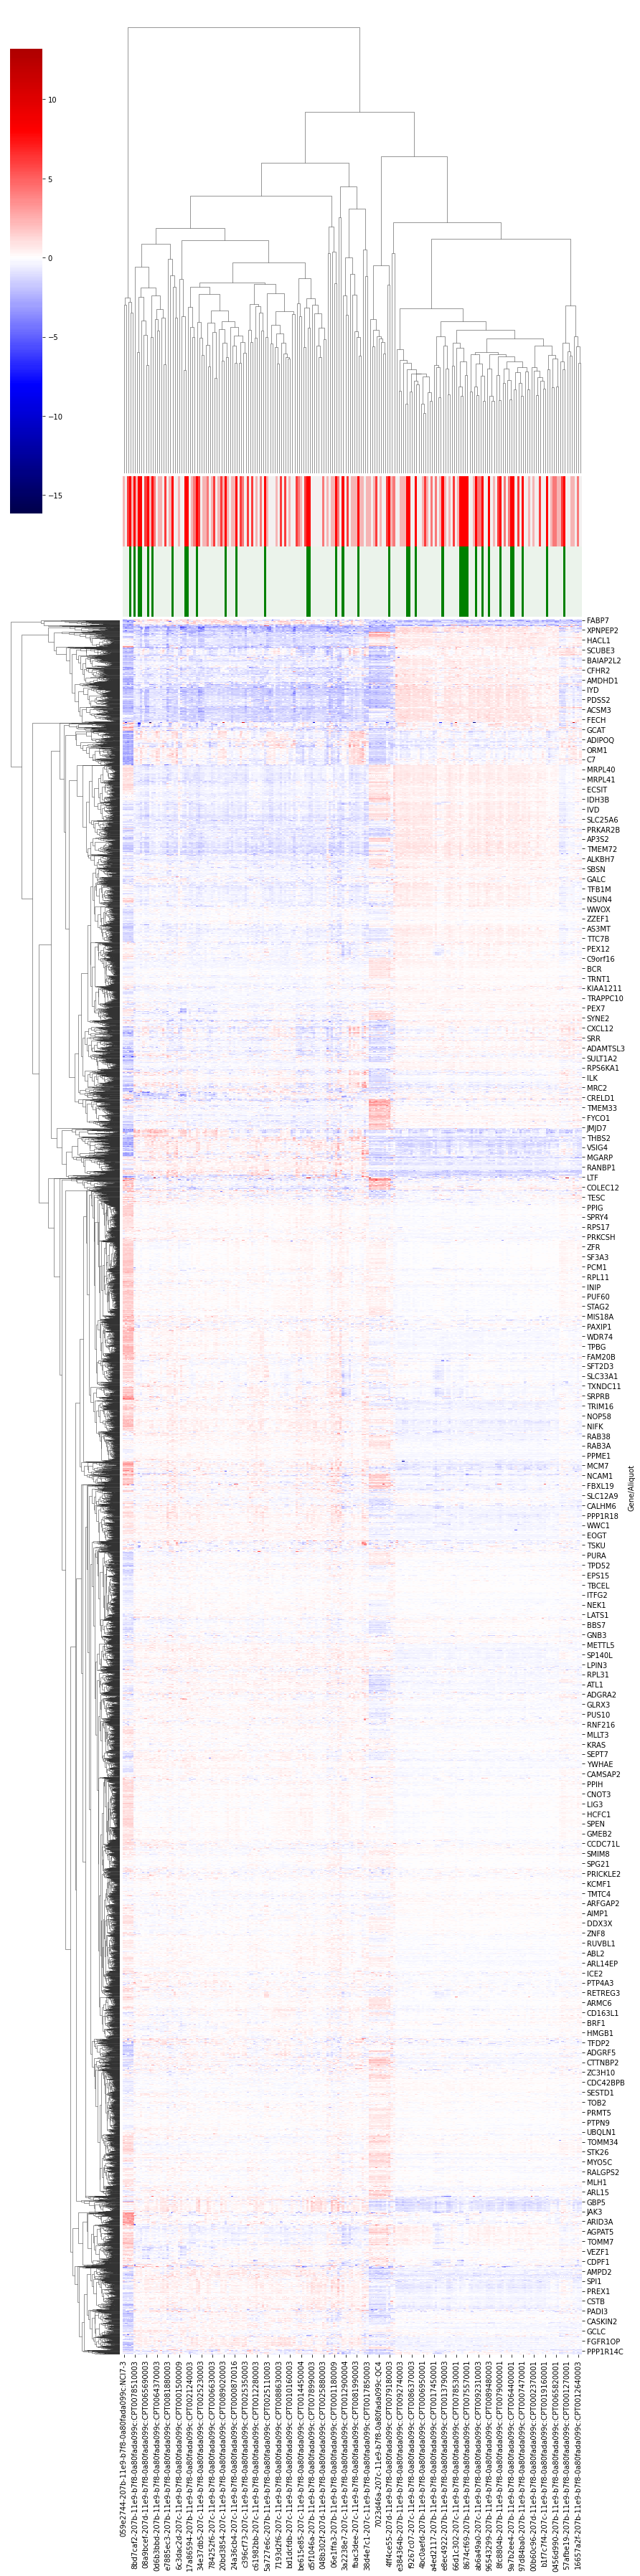

In [56]:
sns.clustermap(ga, metric='euclidean', method='complete', cmap='seismic', mask=ga == mask_na, center=0.,
               col_colors=[stage_col_colors, diagnosis_col_colors], figsize=(12.5, 50))
plt.show()



You could also convert the log2 ratio data to a standard statistic, like z-score.
This can help compress the range, accounting for outliers.

In [59]:
zdf = ga.T.apply(zscore, ddof=len(ga.columns)-1)
zdf = zdf.T

And examine clustering according to that transformation.

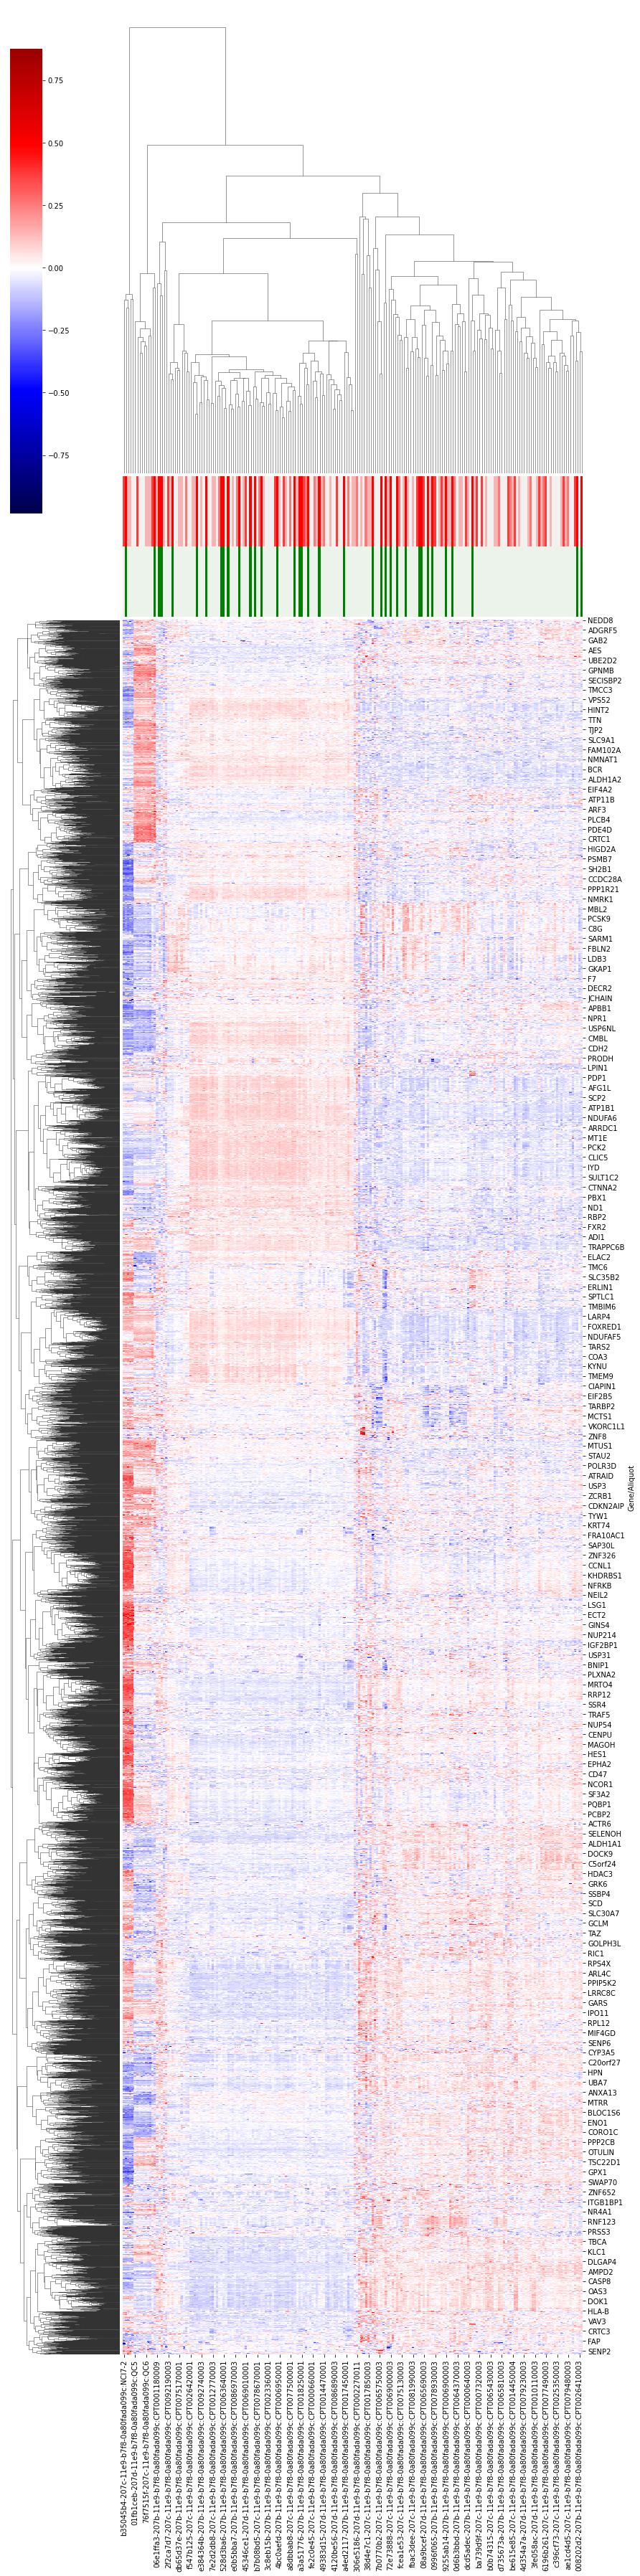

In [60]:
sns.clustermap(zdf, metric='euclidean', method='complete', cmap='seismic', mask=ga == mask_na, center=0.,
               col_colors=[stage_col_colors, diagnosis_col_colors], figsize=(12.5, 50))
plt.show()

Hopefully, the clustermaps have been drawn.  Columns are labeled aliquot_id:aliquot_submitter_id, according to the PDC data model.  Additional work pre-processing the data, removing outliers and batch effects etc., should always be invested on any large-scale analysis.  This ends this example notebook.

We hope that you found this tutorial useful.  There is also an accompanying tutorial on the PDC site, if you are finding this notebook and have not seen the video.  Please submit any questions or requests to: PDCHelpDesk@mail.nih.gov